This notebooks lays out the trading strategy based on VIX prediction and its corresponding backtesting results.

In [1]:
import warnings
warnings.filterwarnings("ignore", message="The frame.append method is deprecated")
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
trading_data = pd.read_csv('/content/drive/My Drive/IAQF_Data/trading_signals (2).csv')
trading_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return,30_day_forward_avg_return,30_day_forward_volatility,...,VIX_Settlement,LSTM_Predicted,Trade_Signal_SPX,30d_MA_VIX,SP500_Returns,Strategy_Returns_SPX,Cumulative_Returns,SP500_Cumulative_Returns,Cumulative_Returns_TSL,Strategy_Returns_Combined
0,2007-01-31,1428.650024,1441.609985,1424.780029,1438.239990,1438.239990,2976690000,0.659288,-0.104071,2.176811,...,16.430000,12.356617,Hold,NaN,0.000000,0.000000,1.0,1.000000,1.0,0.0
1,2007-02-01,1437.900024,1446.640015,1437.900024,1445.939941,1445.939941,2914890000,0.535373,-0.134678,2.539403,...,16.790001,12.701176,Hold,NaN,0.005354,0.005354,1.0,1.005354,1.0,0.0
2,2007-02-02,1445.939941,1449.329956,1444.489990,1448.390015,1448.390015,2569450000,0.169445,-0.104011,2.704556,...,14.590000,13.302481,Hold,NaN,0.001694,0.001694,1.0,1.007057,1.0,0.0
3,2007-02-05,1448.329956,1449.380005,1443.849976,1446.989990,1446.989990,2439430000,-0.096661,-0.079677,2.682342,...,13.270000,13.649921,Hold,NaN,-0.000967,-0.000967,1.0,1.006084,1.0,0.0
4,2007-02-06,1446.979980,1450.189941,1443.400024,1448.000000,1448.000000,2608710000,0.069801,-0.025068,2.732542,...,12.190000,13.637209,Hold,NaN,0.000698,0.000698,1.0,1.006786,1.0,0.0


In [5]:
trading_data['Date'] = pd.to_datetime(trading_data['Date'])
merged_data_final = trading_data[trading_data['Date'] >= pd.Timestamp('2008-01-01')]

In [ ]:
def calculate_sharpe_ratio_corrected(returns, annual_risk_free_rate):
    # Convert annual risk-free rate to daily risk-free rate
    daily_risk_free_rate = (1 + annual_risk_free_rate) ** (1/252) - 1

    # Calculate daily excess returns
    daily_excess_returns = returns - daily_risk_free_rate

    # Calculate the annualized Sharpe ratio
    sharpe_ratio = daily_excess_returns.mean() / daily_excess_returns.std() * np.sqrt(252)
    return sharpe_ratio

merged_data_final['Trade_Signal_SPX'] = 0

# Calculate the 20-day moving average of the VIX (Adj Close_VIX)
merged_data_final['30d_MA_VIX'] = merged_data_final['Adj Close_VIX'].rolling(window=30).mean()

# Define the trading signal
# Long on S&P500 if predicted VIX (LSTM_Predicted) is lower than the 30-day MA of VIX, otherwise short
def determine_trade_signal(row):
    if row['LSTM_Predicted'] < 1.2 * row['30d_MA_VIX']:
        return 'Long'
    elif row['LSTM_Predicted'] > 1.2 * row['30d_MA_VIX']:
        return 'Short'
    else:
        return 'Hold'

merged_data_final['Trade_Signal_SPX'] = merged_data_final.apply(determine_trade_signal, axis=1)


# Calculate daily returns for S&P500
merged_data_final['SP500_Returns'] = merged_data_final['Adj Close'].pct_change().fillna(0)

# Apply the trading strategy
# If Long, use the S&P500 return, if Short, use the negative of the S&P500 return

def calculate_strategy_returns(row):
    if row['Trade_Signal_SPX'] == 'Long':
        return row['SP500_Returns']
    elif row['Trade_Signal_SPX'] == 'Short':
        return -row['SP500_Returns']
    else:
        return 0

def calculate_onlylong_strategy_returns(row):
    if row['Trade_Signal_SPX'] == 'Long':
        return row['SP500_Returns']
    elif row['Trade_Signal_SPX'] == 'Short':
        return 0
    else:
        return 0

def calculate_onlyshort_strategy_returns(row):
    if row['Trade_Signal_SPX'] == 'Long':
        return 0
    elif row['Trade_Signal_SPX'] == 'Short':
        return -row['SP500_Returns']
    else:
        return 0

merged_data_final['Strategy_Returns_LS'] = merged_data_final.apply(calculate_strategy_returns, axis=1)
merged_data_final['Strategy_Returns_L'] = merged_data_final.apply(calculate_onlylong_strategy_returns, axis=1)
merged_data_final['Strategy_Returns_S'] = merged_data_final.apply(calculate_onlyshort_strategy_returns, axis=1)

# Calculate cumulative returns
merged_data_final['Cumulative_Returns_LS'] = (1 + merged_data_final['Strategy_Returns_LS']).cumprod()
merged_data_final['Cumulative_Returns_Long'] = (1 + merged_data_final['Strategy_Returns_L']).cumprod()
merged_data_final['Cumulative_Returns_Short'] = (1 + merged_data_final['Strategy_Returns_S']).cumprod()

# Calculate the number of years in the dataset for CAGR calculation
num_years = (merged_data_final['Date'].iloc[-1] - merged_data_final['Date'].iloc[0]).days / 365.25

# Risk-free rate for Sharpe Ratio calculation
risk_free_rate = 0.0426

In [7]:
merged_data_final['SP500_Cumulative_Returns'] = (1 + merged_data_final['SP500_Returns']).cumprod()

<ipython-input-7-d10dd6c13553>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_final['SP500_Cumulative_Returns'] = (1 + merged_data_final['SP500_Returns']).cumprod()


In [8]:
def calculate_max_drawdown(cumulative_returns):
    """
    Calculate the maximum drawdown of the trading strategy.

    :param cumulative_returns: Series of cumulative returns of the strategy.
    :return: Maximum drawdown in percentage.
    """
    # Calculate the running maximum
    running_max = cumulative_returns.cummax()
    # Calculate the drawdown
    drawdown = (cumulative_returns - running_max) / running_max
    # Calculate the maximum drawdown
    max_drawdown = drawdown.min()
    return max_drawdown

In [9]:
def apply_trailing_stop_loss_strategy(cumulative_returns, trade_signals, trailing_stop_loss_percent):
    """
    Apply a trailing stop-loss strategy to both long and short positions in the trading strategy.

    :param cumulative_returns: Series of cumulative returns of the strategy.
    :param trade_signals: Series of trade signals ('Long', 'Short', or other).
    :param trailing_stop_loss_percent: Trailing stop-loss percentage (in decimal format).
    :return: Series with updated cumulative returns applying the trailing stop-loss strategy.
    """
    peak_value = 1.0
    trough_value = 1.0
    stop_loss_value = 1.0
    updated_cumulative_returns = cumulative_returns.copy()

    for i in range(len(cumulative_returns)):
        current_signal = trade_signals.iloc[i]
        current_return = cumulative_returns.iloc[i]

        if current_signal == 'Long':
            if peak_value is None or current_return > peak_value:
                peak_value = current_return
                stop_loss_value = peak_value * (1 - trailing_stop_loss_percent)
            elif current_return < stop_loss_value:
                updated_cumulative_returns.iloc[i] = stop_loss_value
                # Assuming we exit the position here, so reset peak_value
                peak_value = 1.0

        elif current_signal == 'Short':
            if trough_value is None or current_return < trough_value:
                trough_value = current_return
                stop_loss_value = trough_value * (1 + trailing_stop_loss_percent)
            elif current_return > stop_loss_value:
                updated_cumulative_returns.iloc[i] = stop_loss_value
                # Assuming we exit the position here, so reset trough_value
                trough_value = 1.0

            # Check if current value is above the trailing stop-loss level
            if current_return > stop_loss_value:
                # Stop-loss triggered for short position
                updated_cumulative_returns.iloc[i] = stop_loss_value
                # Reset trough value for the next position
                if i < len(cumulative_returns) - 1:
                    trough_value = updated_cumulative_returns.iloc[i+1]
                    stop_loss_value = trough_value * (1 + trailing_stop_loss_percent)

        else:
            # For other signals, retain the current return value
            updated_cumulative_returns.iloc[i] = current_return

    return updated_cumulative_returns

# Trailing stop-loss percentage (5%)
trailing_stop_loss_percent = 0.05

# Apply trailing stop-loss strategy to the trading strategy
merged_data_final['Cumulative_Returns_TSL'] = apply_trailing_stop_loss_strategy(merged_data_final['Cumulative_Returns_LS'], merged_data_final['Trade_Signal_SPX'], trailing_stop_loss_percent)
merged_data_final['Cumulative_Returns_TSL_OnlyL'] = apply_trailing_stop_loss_strategy(merged_data_final['Cumulative_Returns_Long'], merged_data_final['Trade_Signal_SPX'], trailing_stop_loss_percent)
merged_data_final['Cumulative_Returns_TSL_OnlyS'] = apply_trailing_stop_loss_strategy(merged_data_final['Cumulative_Returns_Short'], merged_data_final['Trade_Signal_SPX'], trailing_stop_loss_percent)


<ipython-input-9-f1d44ced4e3d>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_final['Cumulative_Returns_TSL'] = apply_trailing_stop_loss_strategy(merged_data_final['Cumulative_Returns_LS'], merged_data_final['Trade_Signal_SPX'], trailing_stop_loss_percent)
<ipython-input-9-f1d44ced4e3d>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_final['Cumulative_Returns_TSL_OnlyL'] = apply_trailing_stop_loss_strategy(merged_data_final['Cumulative_Returns_Long'], merged_data_final['Trade_Si

In [10]:
cagr = (merged_data_final['Cumulative_Returns_TSL'].iloc[-1] ** (1 / num_years)) - 1
merged_data_final['Strategy_Returns_Combined'] = merged_data_final['Cumulative_Returns_TSL'].pct_change().fillna(0)

# Calculate the annualized return and standard deviation
annualized_return = merged_data_final['Strategy_Returns_Combined'].mean() * 252
annualized_std_dev = merged_data_final['Strategy_Returns_Combined'].std() * np.sqrt(252)

# Assuming a risk-free rate (e.g., 0.0426 or 4.26%)
risk_free_rate = 0.0426

# Calculate the Sharpe Ratio
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std_dev
annualized_return, annualized_std_dev, cagr, sharpe_ratio

<ipython-input-10-6faa4f253f90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_final['Strategy_Returns_Combined'] = merged_data_final['Cumulative_Returns_TSL'].pct_change().fillna(0)


(0.1676096750844324,
 0.23634365466398488,
 0.1499319111916857,
 0.5289318017112051)

In [11]:
cagr = (merged_data_final['Cumulative_Returns_TSL_OnlyL'].iloc[-1] ** (1 / num_years)) - 1
merged_data_final['Strategy_Returns_Combined_OnlyL'] = merged_data_final['Cumulative_Returns_TSL_OnlyL'].pct_change().fillna(0)

# Calculate the annualized return and standard deviation
annualized_return = merged_data_final['Strategy_Returns_Combined_OnlyL'].mean() * 252
annualized_std_dev = merged_data_final['Strategy_Returns_Combined_OnlyL'].std() * np.sqrt(252)

# Assuming a risk-free rate (e.g., 0.0426 or 4.26%)
risk_free_rate = 0.0426

# Calculate the Sharpe Ratio
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std_dev
annualized_return, annualized_std_dev, cagr, sharpe_ratio

<ipython-input-11-252daf414b17>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_final['Strategy_Returns_Combined_OnlyL'] = merged_data_final['Cumulative_Returns_TSL_OnlyL'].pct_change().fillna(0)


(0.13555240780384242,
 0.21832327254826212,
 0.11816568696824814,
 0.42575583774878856)

In [12]:
cagr = (merged_data_final['Cumulative_Returns_TSL_OnlyS'].iloc[-1] ** (1 / num_years)) - 1
merged_data_final['Strategy_Returns_Combined_OnlyS'] = merged_data_final['Cumulative_Returns_TSL_OnlyS'].pct_change().fillna(0)

# Calculate the annualized return and standard deviation
annualized_return = merged_data_final['Strategy_Returns_Combined_OnlyS'].mean() * 252
annualized_std_dev = merged_data_final['Strategy_Returns_Combined_OnlyS'].std() * np.sqrt(252)

# Assuming a risk-free rate (e.g., 0.0426 or 4.26%)
risk_free_rate = 0.0426

# Calculate the Sharpe Ratio
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std_dev
annualized_return, annualized_std_dev, cagr, sharpe_ratio

<ipython-input-12-f8117c4abbb8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_final['Strategy_Returns_Combined_OnlyS'] = merged_data_final['Cumulative_Returns_TSL_OnlyS'].pct_change().fillna(0)


(0.04350856286230002,
 0.17662090811947634,
 0.028409228250928953,
 0.005144141041814905)

In [13]:
cagr = (merged_data_final['SP500_Cumulative_Returns'].iloc[-1] ** (1 / num_years)) - 1
merged_data_final['Strategy_Returns_SPX'] = merged_data_final['SP500_Cumulative_Returns'].pct_change().fillna(0)

# Calculate the annualized return and standard deviation
annualized_return = merged_data_final['SP500_Returns'].mean() * 252
annualized_std_dev = merged_data_final['SP500_Returns'].std() * np.sqrt(252)

# Assuming a risk-free rate (e.g., 0.0426 or 4.26%)
risk_free_rate = 0.0426

# Calculate the Sharpe Ratio
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std_dev
annualized_return, annualized_std_dev, cagr, sharpe_ratio

<ipython-input-13-12fb6d538930>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_final['Strategy_Returns_SPX'] = merged_data_final['SP500_Cumulative_Returns'].pct_change().fillna(0)


(0.09152936653612352,
 0.2056843274365392,
 0.07279255349368863,
 0.2378857307502923)

In [14]:
max_drawdown = calculate_max_drawdown(merged_data_final['Cumulative_Returns_TSL'])
max_drawdown_percentage = max_drawdown * 100  # Convert to percentage

max_drawdown_percentage

-26.971611807109074

In [15]:
max_drawdown = calculate_max_drawdown(merged_data_final['SP500_Cumulative_Returns'])
max_drawdown_percentage = max_drawdown * 100  # Convert to percentage

max_drawdown_percentage

-53.25119453927664

In [16]:
max_drawdown = calculate_max_drawdown(merged_data_final['Cumulative_Returns_TSL_OnlyL'])
max_drawdown_percentage = max_drawdown * 100  # Convert to percentage

max_drawdown_percentage

-20.14632089844744

In [17]:
max_drawdown = calculate_max_drawdown(merged_data_final['Cumulative_Returns_TSL_OnlyS'])
max_drawdown_percentage = max_drawdown * 100  # Convert to percentage

max_drawdown_percentage

-26.860888271747164

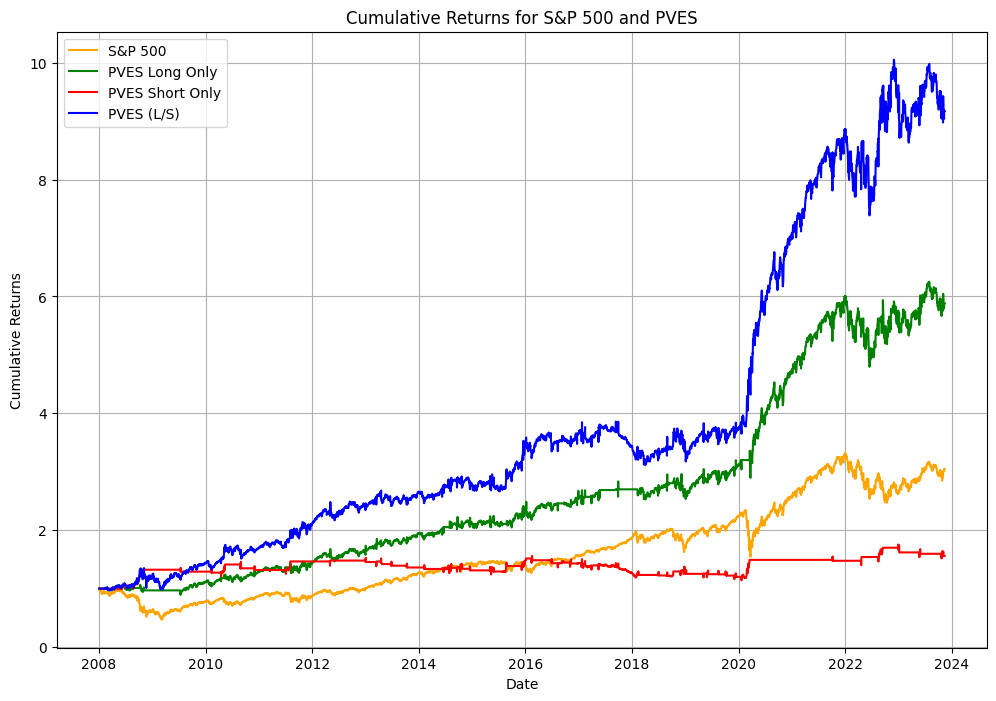

In [18]:
# Plotting the cumulative returns with trailing stop-loss strategy
plt.figure(figsize=(12, 8))
plt.plot(merged_data_final['Date'], merged_data_final['SP500_Cumulative_Returns'], label='S&P 500', color='orange')
plt.plot(merged_data_final['Date'], merged_data_final['Cumulative_Returns_TSL_OnlyL'], label='PVES Long Only', color='green')
plt.plot(merged_data_final['Date'], merged_data_final['Cumulative_Returns_TSL_OnlyS'], label='PVES Short Only', color='red')
plt.plot(merged_data_final['Date'], merged_data_final['Cumulative_Returns_TSL'], label='PVES (L/S)', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns for S&P 500 and PVES')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.stats.diagnostic import het_white

def newey_west_analysis(strategy_returns, benchmark_returns):
    # Ensure that the data is in DataFrame format and align the indices
    strategy_df = pd.DataFrame(strategy_returns, columns=['Strategy_Returns_Combined'])
    benchmark_df = pd.DataFrame(benchmark_returns, columns=['Strategy_Returns_SPX'])
    combined_df = strategy_df.join(benchmark_df, how='inner')

    # Define the independent variable (benchmark returns) and add a constant
    X = combined_df['Strategy_Returns_SPX']
    X = sm.add_constant(X)

    # Define the dependent variable (strategy returns)
    Y = combined_df['Strategy_Returns_Combined']

    # Perform the regression using Newey-West standard errors
    model = sm.OLS(Y, X).fit(cov_type='HAC',cov_kwds={'maxlags':1})

    # Output the summary of the regression
    return model.summary()

# Example usage
strategy_returns = merged_data_final
benchmark_returns = merged_data_final
result = newey_west_analysis(strategy_returns, benchmark_returns)
print(result)

                                OLS Regression Results                               
Dep. Variable:     Strategy_Returns_Combined   R-squared:                       0.209
Model:                                   OLS   Adj. R-squared:                  0.209
Method:                        Least Squares   F-statistic:                     110.8
Date:                       Wed, 27 Mar 2024   Prob (F-statistic):           1.42e-25
Time:                               05:39:12   Log-Likelihood:                 11608.
No. Observations:                       3995   AIC:                        -2.321e+04
Df Residuals:                           3993   BIC:                        -2.320e+04
Df Model:                                  1                                         
Covariance Type:                         HAC                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

In [20]:
def newey_west_analysis(strategy_returns, benchmark_returns):
    # Ensure that the data is in DataFrame format and align the indices
    strategy_df = pd.DataFrame(strategy_returns, columns=['Strategy_Returns_Combined_OnlyL'])
    benchmark_df = pd.DataFrame(benchmark_returns, columns=['Strategy_Returns_SPX'])
    combined_df = strategy_df.join(benchmark_df, how='inner')

    # Define the independent variable (benchmark returns) and add a constant
    X = combined_df['Strategy_Returns_SPX']
    X = sm.add_constant(X)

    # Define the dependent variable (strategy returns)
    Y = combined_df['Strategy_Returns_Combined_OnlyL']

    # Perform the regression using Newey-West standard errors
    model = sm.OLS(Y, X).fit(cov_type='HAC',cov_kwds={'maxlags':1})

    # Output the summary of the regression
    return model.summary()

# Example usage
strategy_returns = merged_data_final
benchmark_returns = merged_data_final
result = newey_west_analysis(strategy_returns, benchmark_returns)
print(result)

                                   OLS Regression Results                                  
Dep. Variable:     Strategy_Returns_Combined_OnlyL   R-squared:                       0.212
Model:                                         OLS   Adj. R-squared:                  0.212
Method:                              Least Squares   F-statistic:                     162.3
Date:                             Wed, 27 Mar 2024   Prob (F-statistic):           1.77e-36
Time:                                     05:39:12   Log-Likelihood:                 11932.
No. Observations:                             3995   AIC:                        -2.386e+04
Df Residuals:                                 3993   BIC:                        -2.385e+04
Df Model:                                        1                                         
Covariance Type:                               HAC                                         
                           coef    std err          z      P>|z|      [0.025    

In [21]:
def newey_west_analysis(strategy_returns, benchmark_returns):
    # Ensure that the data is in DataFrame format and align the indices
    strategy_df = pd.DataFrame(strategy_returns, columns=['Strategy_Returns_Combined_OnlyS'])
    benchmark_df = pd.DataFrame(benchmark_returns, columns=['Strategy_Returns_SPX'])
    combined_df = strategy_df.join(benchmark_df, how='inner')

    # Define the independent variable (benchmark returns) and add a constant
    X = combined_df['Strategy_Returns_SPX']
    X = sm.add_constant(X)

    # Define the dependent variable (strategy returns)
    Y = combined_df['Strategy_Returns_Combined_OnlyS']

    # Perform the regression using Newey-West standard errors
    model = sm.OLS(Y, X).fit(cov_type='HAC',cov_kwds={'maxlags':1})

    # Output the summary of the regression
    return model.summary()

# Example usage
strategy_returns = merged_data_final
benchmark_returns = merged_data_final
result = newey_west_analysis(strategy_returns, benchmark_returns)
print(result)

                                   OLS Regression Results                                  
Dep. Variable:     Strategy_Returns_Combined_OnlyS   R-squared:                       0.032
Model:                                         OLS   Adj. R-squared:                  0.032
Method:                              Least Squares   F-statistic:                     47.56
Date:                             Wed, 27 Mar 2024   Prob (F-statistic):           6.17e-12
Time:                                     05:39:12   Log-Likelihood:                 12368.
No. Observations:                             3995   AIC:                        -2.473e+04
Df Residuals:                                 3993   BIC:                        -2.472e+04
Df Model:                                        1                                         
Covariance Type:                               HAC                                         
                           coef    std err          z      P>|z|      [0.025    